# Library Imports.
pyspark = "Python for Spark". Importing basic functions.  
udf = Spark's "User Defined Function"
### BigDL-specific imports  
transform = image transformation library (resize, crop, color-correct) https://bigdl-project.github.io/0.5.0/#APIGuide/Transformer/  
optim = loss function optimization library https://bigdl-project.github.io/0.5.0/#APIGuide/Optimizers/Optimizer/   
layer = Neural network layers library https://bigdl-project.github.io/0.5.0/#APIGuide/Layers/Simple-Layers/

In [1]:
import re #import regular expressions
from bigdl.util.common import *
from bigdl.transform.vision.image import *
from bigdl.transform.vision import image
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from bigdl.optim.optimizer import Adam #we actually use SGD (stochastic gradient descent, so this is superflous)

## Data Processing Pipeline Imports
ImageTransform => ModelImport => ModelTraining => ImageClassificaiton

In [2]:
from zoo.common.nncontext import *
from zoo.pipeline.nnframes.nn_classifier import *
from zoo.pipeline.nnframes.nn_image_reader import *
from zoo.pipeline.nnframes.nn_image_transformer import *

In [3]:
#for image display
from IPython.display import Image

## Setup
Configuring Spark Context ("sc").  
- It establishes connection between this code and Spark execution environment.  
- Lets us use Spark distributed primitives (e.g RDD - Resilient Distributed Dataset).  
- Allows us to parallelize this code among multiple compute cores.  
- Specifies number of partitions to break the dataset into (usually x2-x3 the number of available cores)

In [4]:
model_def_path = 'models/googlenet_places365.prototxt_modified'
model_weight_path = 'models/googlenet_places365.caffemodel'
image_path = 'images/*/*'
sparkConf = SparkConf().setAppName("ImageTransferLearningExample")
sc = get_nncontext(sparkConf) #setting Spark Context (sc)
redire_spark_logs()  # making spark messages visible
imageDF = NNImageReader.readImages(image_path, sc).repartition(8) # creates image dataframes and 
                                                                  # separates them into 8 partitions

# Real Code begins here. 
using Spark's UDFs to  create a dataframe with labels  
'getName' UDF  returns the 1st word of the row. When we later call it as 'getName(col("image")), it returns the file path for each image.  
'getLabel' UDF returns a label {1,2,3,4} based on the word label of the image ('contemporary', etc) 


In [5]:
getName = udf(lambda row: row[0], StringType())
def nameToLabel(name):
    if 'contemporary' in name:
        return 1.0
    elif 'mediterranean' in name:
        return 2.0
    elif 'ranch' in name:
        return 3.0
    else: # 'traditional' style
        return 4.0

getLabel = udf(lambda name: nameToLabel(name), DoubleType())
labelDF = imageDF.withColumn("name", getName(col("image"))) \
    .withColumn("label", getLabel(col('name'))).cache() 
print("Ground Truth Labels and image count")
labelDF.groupBy("label").count().show(10, False)
print("This is what Spark DataFrame schema looks like")
labelDF.show(3, True)
print("Same dataframe but with full schema names")
labelDF.show(3, False)
# .cache() is here because we want to keep labelDF in cache rather than recomputing it every time labelDF is used

Ground Truth Labels and image count
+-----+-----+
|label|count|
+-----+-----+
|1.0  |658  |
|4.0  |445  |
|3.0  |1018 |
|2.0  |780  |
+-----+-----+

This is what Spark DataFrame schema looks like
+--------------------+--------------------+-----+
|               image|                name|label|
+--------------------+--------------------+-----+
|[file:/Users/sver...|file:/Users/sverm...|  1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|
+--------------------+--------------------+-----+
only showing top 3 rows

Same dataframe but with full schema names
+----------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+-----+
|image                                                                                                                 |name                                            

## Data preprocessing step:  
- split dataset into training (90%) and validation (10%)
- scale, color-normalize, and crop images to 224x224 pixels as required by GoogleNet model
- import GoogleNet image recognition model
- expose last layer as 1024-long vector of "embeddings"
- NNModel renders a BigDL module as a Spark ML's Transformer which then can be processed by standard Spark pipelines. For more info on NNModel: https://github.com/intel-analytics/zoo/blob/master/docs/nnframes/NNEstimator.md 
- Note 1: these specific color channel normalization numbers are the same as used for training the original GoogleNet model
- Note 2: the image processing here is very similar to python PIL or Pillow. But it runs on Spark.  
### At this point, we are still just setting things up. No model iterations have been done yet

In [6]:
    (trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])
    numClasses = 4

    # compose a pipeline that includes feature transform, pretrained model and Logistic Regression
    transformer = NNImageTransformer(
        image.Pipeline([Resize(256, 256), CenterCrop(224, 224), ChannelNormalize(123.0, 117.0, 104.0)])
    ).setInputCol("image").setOutputCol("features")

    caffeModel = Model.load_caffe_model(model_def_path, model_weight_path)
    preTrainedNNModel = NNModel(caffeModel, [3,224,224]).setPredictionCol("embedding")

creating: createResize
creating: createCenterCrop
creating: createChannelNormalize
creating: createPipeline
creating: createNNImageTransformer
creating: createNNModel


## This is important!
To increase the training speed, we *do not* train the entire 22-layer GoogleNet deep learning network.  
Instead, we use GoogleNet neural net to convert a 224x224x3 image to 1024-long "embeddings vector". Then we use a simple and fast logistics regression to separate the all ~2000 1024-long embedding vectors into 4 classes (contemporary, mediterranian, ranch, traditional).  
There is no free lunch, however - more on this later.

## Actual Machine Learning happens here:  
### Classifier setup
- Instantiate a linear logistics regresion model with four classes and softmax "activation" function
'Sequential' as a container in BigDL that allows one to link NN layers together to build a neural network.  
https://bigdl-project.github.io/0.5.0/#APIGuide/Layers/Containers/#sequential
- Set up a classifier with LearningRate, BatchSize, Epoch count.  
### Definitions:
-  Learning rate: fraction of the calculated gradient that's applied to the estimate: w:= w - lr*grad(Qloss).
- BatchSize: how many images we use in each iteration of gradient descent update. grad = sum(grad_i) / BatchSize.
- Epoch: number of iterations needed to process all images. iterations_per_epoch = TotalNumberImages / BatchSize.  
  
  Note that we are not applying a convergence criteria here. We just let the calculations rip for 100 epochs. We could specify a convergence criteria for loss functions, but chose coding simplicity vs speed optimization. 

In [7]:
    lrModel = Sequential().add(Linear(1024, numClasses)).add(LogSoftMax())
    classifier = NNClassifier(lrModel, ClassNLLCriterion(), [1024]) \
        .setLearningRate(1e-3).setBatchSize(40).setMaxEpoch(100).setFeaturesCol("embedding") 

creating: createSequential
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createNNClassifier


### Pipeline setup and classifier fit optimization:  
- link transformer, GoogleNet model, and linear classifier into one Spark pipeline. 'Pipeline' is a standard Spark ML pipeline primitive
- invoke Stochastic Gradient Descent and iterate on Training Data
- the result is HouseStyleModel  
This may take a while (~5-10 min)

In [8]:
    pipeline = Pipeline(stages=[transformer, preTrainedNNModel, classifier])
    HouseStyleModel = pipeline.fit(trainingDF)

### Prediction Validation stage (This is what you would deploy in production)  
- create prediction DataFrame based on 10% of holdout validation data. 
- set up an evaluator MulticlassClassificationEvaluator (yet another Spark ML primitive) that processes entire validation data subset
- calculate accuracy = correct_predition/total_validation_images
- output error (1 - accuracy)

In [9]:
    predictionDF = HouseStyleModel.transform(validationDF)
    predictionDF.show()

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictionDF)
    # expected error should be less than 20%
    print("Test Error = %g " % (1.0 - accuracy))

+--------------------+--------------------+-----+--------------------+--------------------+----------+
|               image|                name|label|            features|           embedding|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+----------+
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.05616474151611...|       1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.26928561925888...|       1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.60283917188644...|       4.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.0, 1.178776979...|       1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.00562847265973...|       3.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.02966126613318...|       1.0|
|[file:/Users/sver...|file:/Users/sverm...|  1.0|[file:/Users/sver...|[0.

In [10]:
predictionDF.select("image").show(10, False)

+-----------------------------------------------------------------------------------------------------------------------+
|image                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|[file:/Users/svermoli/sandbox/images/contemporary/15-Neat-Contemporary-Home-Exterior-D-1.jpg,420,630,3,16,[B@41931d6d] |
|[file:/Users/svermoli/sandbox/images/contemporary/Gray-contemporary-exterior-and-home-.jpg,704,1000,3,16,[B@3baada75]  |
|[file:/Users/svermoli/sandbox/images/contemporary/Modern+homes+USA+front+designs+exter.jpg,853,1280,3,16,[B@f2216a8]   |
|[file:/Users/svermoli/sandbox/images/contemporary/Modern+house+exterior++front+designs-2.jpg,300,360,3,16,[B@12831e7b] |
|[file:/Users/svermoli/sandbox/images/contemporary/contemporary-exterior-42.jpg,432,640,3,16,[B@4b220133]               |
|[file:/Users/svermoli/s

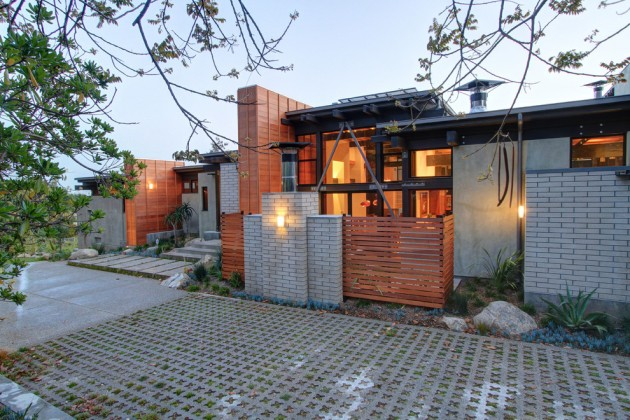

In [11]:
#open -a preview /Users/svermoli/sandbox/images/contemporary/15-Neat-Contemporary-Home-Exterior-D-1.jpg
filename = "/Users/svermoli/sandbox/images/contemporary/15-Neat-Contemporary-Home-Exterior-D-1.jpg"
Image(filename)

In [12]:
#scratchpad
f = lambda x, y : x + y
f(3,4)

7